# 🚜Predicting the Sale Price of Bulldozers using Machine Learning

Going through an example machine learning project with the goal of predicting the sale price of bulldozers. Since the prediction is a number, this kind of problem is known as a **regression problem**.

## 1. Problem definition

> How well can one predict the future sale price of a bulldozer, given its characteristics and previous example of how much similar bullzoders have been sold for?

## 2. Data

The data is downloaded from Kaggle - Bluebook for Bulldozers competition:
https://www.kaggle.com/c/bluebook-for-bulldozers/data

In this case, it is historical data of bulldozers, including things like: model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what it has to be predicted).

## 3. Evaluation

[Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well the model is doing, the RMSLE will be computed and then compare the results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).


## 4. Features

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. 

One can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

First step is importing the dataset and start exploring. Since the evaluation metric is known, the first goal will be building a baseline model and seeing how it stacks up against the competition.

### Importing the data and preparing it for modelling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
# Import training and validation sets
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv",
                 low_memory=False)

Now that the data has been imported, it can be explored.

In [96]:
# Checking details about the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [4]:
# Checking for missing values
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

A first look over saledate vs SalePrice columns.

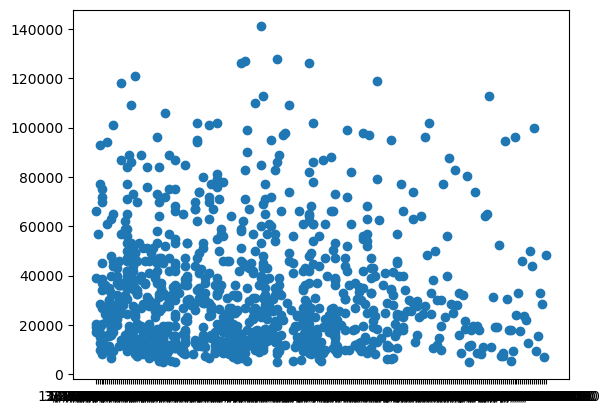

In [5]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [6]:
df["saledate"][:1000], df["saledate"].dtype

(0      11/16/2006 0:00
 1       3/26/2004 0:00
 2       2/26/2004 0:00
 3       5/19/2011 0:00
 4       7/23/2009 0:00
             ...       
 995     7/16/2009 0:00
 996     6/14/2007 0:00
 997     9/22/2005 0:00
 998     7/28/2005 0:00
 999     6/16/2011 0:00
 Name: saledate, Length: 1000, dtype: object,
 dtype('O'))

As it can be observed, the plot cannot provide any insight for now because the `saledate` column's type is object and not a datetime object type.

<Axes: ylabel='Frequency'>

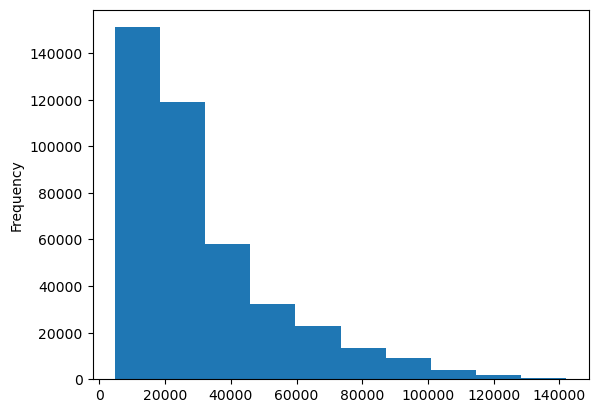

In [7]:
# Checking the distribution of SalePrice column
df["SalePrice"].plot.hist()

The SalePrice with the biggest frequency is around 20000$.

### Parsing dates

Using `parse_dates` parameter to convert the **saledate** column into a `datetime` object.


In [8]:
# Import the data again but using parse dates parameter
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv", 
                 parse_dates=["saledate"],
                 low_memory=False)

In [9]:
# Checking the type of saledate column
df["saledate"].dtype

dtype('<M8[ns]')

In [10]:
# Checking the new format of the column after converting it in datetime object
df["saledate"][:1000]

0     2006-11-16
1     2004-03-26
2     2004-02-26
3     2011-05-19
4     2009-07-23
         ...    
995   2009-07-16
996   2007-06-14
997   2005-09-22
998   2005-07-28
999   2011-06-16
Name: saledate, Length: 1000, dtype: datetime64[ns]

Now that the `saledate` column has been converted, the data can be plotted again.

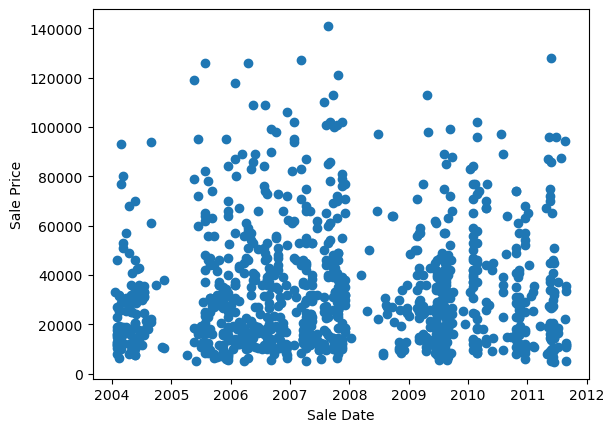

In [11]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])
ax.set_xlabel("Sale Date")
ax.set_ylabel("Sale Price");

One may notice that the plot provides some information as: there are some gaps corresponding to years 2005 and 2008 when not so many bulldozers were sold, however in years 2004, 2006-2008 and 2009-2010, there is a heavy selling of bulldozers with range price 20000-40000$.

In [12]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Checking all columns
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [14]:
df["saledate"].head(20)

0    2006-11-16
1    2004-03-26
2    2004-02-26
3    2011-05-19
4    2009-07-23
5    2008-12-18
6    2004-08-26
7    2005-11-17
8    2009-08-27
9    2007-08-09
10   2008-08-21
11   2006-08-24
12   2005-10-20
13   2006-01-26
14   2006-01-03
15   2006-11-16
16   2007-06-14
17   2010-01-28
18   2006-03-09
19   2005-11-17
Name: saledate, dtype: datetime64[ns]

### Sort DataFrame by saledate

As one is working with time series and is trying to predict future examples given past examples, it makes sense to sort the data by date.

In [15]:
# Sort DataFrame in date order
df.sort_values(by=["saledate"], inplace=True, ascending=True)

In [16]:
df["saledate"].head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

### Make a copy of the original DataFrame

Since preprocessing step implies a lot of data manipulation, a copy of the original DataFrame is made to perform the changes there.

The purpose of this step is to keep the original DataFrame in tact if it is needed again.

In [17]:
# Make a copy
df_temp = df.copy()

In [18]:
df_temp["saledate"].head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [19]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


### Add datetime parameters for `saledate` column

It is important to take advantage of the time series and enrich the dataset with as much information as possible.


Because the `saledate` column was converted into a datatime object, one can now access the different [datetime attributes](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.html).

In [20]:
# Add datetime parameters for saledate
df_temp["saleYear"] = df_temp["saledate"].dt.year
df_temp["saleMonth"] = df_temp["saledate"].dt.month
df_temp["saleDay"] = df_temp["saledate"].dt.day
df_temp["saleDayOfWeek"] = df_temp["saledate"].dt.dayofweek
df_temp["saleDayOfYear"] = df_temp["saledate"].dt.dayofyear

In [21]:
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [22]:
# the DataFrame has been enriched with date time features so saledate can be removed
df_temp.drop("saledate", axis=1, inplace=True)

In [23]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [24]:
# Check the values of different columns
df_temp["state"].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [25]:
len(df_temp)

412698

## 5. Modelling

Now that the dataset has been explored a little as well as enriched with some datetime attributes, one can try to model it (perform some model-driven EDA) because the evaluation metric is already known. 

Following the [Scikit-Learn machine learning map](https://scikit-learn.org/stable/machine_learning_map.html), `RandomForestRegressor()` might be a good choice.

In [26]:
# Import the model
from sklearn.ensemble import RandomForestRegressor

However, modelling is not working right now since the data contains some missing values and not all columns are numeric.

Some processing is needed.

In [27]:
# Check for missing categories and different datatypes
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-null   o

In [28]:
# Check for missing values
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Convert strings to categories

Turning all data into numbers by converting them into pandas categories ([using pandas type API](https://pandas.pydata.org/docs/reference/arrays.html)).

In [29]:
# Check the data..again
df_temp.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [30]:
pd.api.types.is_object_dtype(df_temp["UsageBand"])

True

In [31]:
# Find and check the columns which contain object datatype
for label, content in df_temp.items():
    if pd.api.types.is_object_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [32]:
# Turning all of the string values into category values
for label, content in df_temp.items():
    if pd.api.types.is_object_dtype(content):
        df_temp[label] = content.astype("category").cat.as_ordered()

In [33]:
# Check if there are any object columns left
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

In [34]:
# Check how state column looks like after conversion
df_temp["state"].cat.categories

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin',
       'Wyoming'],
      dtype='object')

In [35]:
df_temp["state"].value_counts()

state
Florida           67320
Texas             53110
California        29761
Washington        16222
Georgia           14633
Maryland          13322
Mississippi       13240
Ohio              12369
Illinois          11540
Colorado          11529
New Jersey        11156
North Carolina    10636
Tennessee         10298
Alabama           10292
Pennsylvania      10234
South Carolina     9951
Arizona            9364
New York           8639
Connecticut        8276
Minnesota          7885
Missouri           7178
Nevada             6932
Louisiana          6627
Kentucky           5351
Maine              5096
Indiana            4124
Arkansas           3933
New Mexico         3631
Utah               3046
Unspecified        2801
Wisconsin          2745
New Hampshire      2738
Virginia           2353
Idaho              2025
Oregon             1911
Michigan           1831
Wyoming            1672
Montana            1336
Iowa               1336
Oklahoma           1326
Nebraska            866
West Virgi

In [36]:
df_temp["state"].cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

Now, thanks to pandas Categories one has a way to access all of its data in the form of numbers.

However, there is still a bunch of missing data...

In [37]:
# Check missing data as procentages
df_temp.isnull().sum()/len(df_temp)*100

SalesID                      0.000000
SalePrice                    0.000000
MachineID                    0.000000
ModelID                      0.000000
datasource                   0.000000
auctioneerID                 4.879113
YearMade                     0.000000
MachineHoursCurrentMeter    64.258610
UsageBand                   82.149174
fiModelDesc                  0.000000
fiBaseModel                  0.000000
fiSecondaryDesc             34.099269
fiModelSeries               85.784520
fiModelDescriptor           81.871490
ProductSize                 52.485110
fiProductClassDesc           0.000000
state                        0.000000
ProductGroup                 0.000000
ProductGroupDesc             0.000000
Drive_System                74.051970
Enclosure                    0.080931
Forks                       52.092087
Pad_Type                    80.349796
Ride_Control                62.992794
Stick                       80.349796
Transmission                54.444412
Turbocharged

### Save preprocessed data

In the current format the data is in, it is still good to be worked with so it will be saved to a file and reimported.

In [38]:
# Export current temp dataframe
df_temp.to_csv("data/bluebook-for-bulldozers/train_temp.csv",
               index=False)

In [39]:
# Import preprocessed data
df_temp = pd.read_csv("data/bluebook-for-bulldozers/train_temp.csv",
                      low_memory=False)

In [40]:
# Check if the importing worked as expected
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [41]:
# Back to missing values
df_temp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

### Fill missing values

As it may be seen above, the data still has plenty of missing values that need to be filled.

#### Numeric missing values

Any numeric column with missing values will be filled with the median of that column.

In [42]:
# Check which columns are numeric
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [43]:
df_temp["ModelID"]

0          8434
1         10150
2          4139
3          8591
4          4089
          ...  
412693     5266
412694    19330
412695    17244
412696     3357
412697     4701
Name: ModelID, Length: 412698, dtype: int64

In [44]:
# Check for which numeric columns have null values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

auctioneerID
MachineHoursCurrentMeter


In [45]:
# Fill numeric rows with the median
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            # Add a binary column which tells us if the data was missing
            df_temp[label+"_is_missing"] = pd.isnull(content)
            # Fill missing numeric values with median
            df_temp[label] = content.fillna(content.median())

Using the median because it is more robust than the mean.

The reason behind adding a binary column indicating whether the data was missing or not is to retain its absence.

In [46]:
# Check if there are any null numeric values
for label, content in df_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            print(label)

Checking if the binary column has been filled as expected by comparing the number of `True` values in the new column `auctioneerID_is_missing` with the number of missing values provided by `df_temp.isna().sum()` above.

In [47]:
# Check to see how many auctioneerID were missing (the true no should be the same as above with df_temp.isna().sum())
df_temp["auctioneerID_is_missing"].value_counts()

auctioneerID_is_missing
False    392562
True      20136
Name: count, dtype: int64

In [48]:
# Check for the left missing values
df_temp.isna().sum()

SalesID                                     0
SalePrice                                   0
MachineID                                   0
ModelID                                     0
datasource                                  0
auctioneerID                                0
YearMade                                    0
MachineHoursCurrentMeter                    0
UsageBand                              339028
fiModelDesc                                 0
fiBaseModel                                 0
fiSecondaryDesc                        140727
fiModelSeries                          354031
fiModelDescriptor                      337882
ProductSize                            216605
fiProductClassDesc                          0
state                                       0
ProductGroup                                0
ProductGroupDesc                            0
Drive_System                           305611
Enclosure                                 334
Forks                             

#### Categorical variables into numbers

Doing the same for categorical values at the same time as turning them into numbers.

In [49]:
# Check for columns which are not numeric (so they are categories)
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [50]:
# Turn categorical variables into numbers and fill missing
for label, content in df_temp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Add binary column to indicate whether sample had missing value
        df_temp[label+"_is_missing"] = pd.isnull(content)
        # Turn categories into numbers and add + 1
        df_temp[label] = pd.Categorical(content).codes+1

Adding 1 to the categorical code because when a value is missing, the default categorical code is -1. 

In [51]:
# Check if it worked for state column
pd.Categorical(df_temp["state"]).codes

array([43,  8,  8, ...,  4,  4,  4], dtype=int8)

In [52]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Columns: 103 entries, SalesID to Steering_Controls_is_missing
dtypes: bool(46), float64(3), int16(4), int64(10), int8(40)
memory usage: 77.9 MB


In [53]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


In [54]:
# Last check of missing values
df_temp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

Now that all data is numeric and the DataFrame has no missing values, one is able to build a machine learning model.

In [55]:
df_temp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True


In [56]:
%%time
# Instantiate model
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)

# Fit the model
model.fit(df_temp.drop("SalePrice", axis=1), df_temp["SalePrice"])

CPU times: total: 21min 43s
Wall time: 2min 19s


RandomForestRegressor(n_jobs=-1, random_state=42)

However, this takes few minutes which is too long for interacting with it so one will create a subset of rows to work with below.

In [57]:
# Score the model
model.score(df_temp.drop("SalePrice", axis=1), df_temp["SalePrice"])

0.9875468079970562

**However the metric above is not reliable because the evaluation is done on the same data as the model is trained on.**

### Splitting data into train/validation sets

In [58]:
df_temp.head().T

,0,1,2,3,4
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
...,...,...,...,...,...
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Type_is_missing,False,True,False,True,False
Travel_Controls_is_missing,False,True,False,True,False
Differential_Type_is_missing,True,False,True,False,True


According to Kaggle data page, the validation set and test set are split according to dates. Which makes sense since working with time series.

Knowing this, randomly splitting the data into train and test sets using something like `train_test_split()` would not work.

Instead, one splits the data into training, validation and test sets using the date each sample occured.

In this case:
* Training = all samples up until 2011
* Valid = all samples form January 1, 2012 - April 30, 2012
* Test = all samples from May 1, 2012 - November 2012

In [59]:
df_temp["saleYear"]

0         1989
1         1989
2         1989
3         1989
4         1989
          ... 
412693    2012
412694    2012
412695    2012
412696    2012
412697    2012
Name: saleYear, Length: 412698, dtype: int64

In [60]:
df_temp["saleYear"].value_counts()

saleYear
2009    43849
2008    39767
2011    35197
2010    33390
2007    32208
2006    21685
2005    20463
2004    19879
2001    17594
2000    17415
2002    17246
2003    15254
1998    13046
1999    12793
2012    11573
1997     9785
1996     8829
1995     8530
1994     7929
1993     6303
1992     5519
1991     5109
1989     4806
1990     4529
Name: count, dtype: int64

In [61]:
# Sort the columns alphabetically
sorted_columns = sorted(df_temp.columns)

# Reorder the DataFrame using the sorted columns
df_temp_sorted = df_temp[sorted_columns]

# Split data into training and validation
df_valid = df_temp_sorted[df_temp_sorted["saleYear"] == 2012]
df_train = df_temp_sorted[df_temp_sorted["saleYear"] != 2012]

len(df_valid), len(df_train)

(11573, 401125)

In [62]:
# Split data into X and y
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_valid, y_valid = df_valid.drop("SalePrice", axis=1), df_valid["SalePrice"]

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [63]:
y_train

0          9500.0
1         14000.0
2         50000.0
3         16000.0
4         22000.0
           ...   
401120    29000.0
401121    11000.0
401122    11000.0
401123    18000.0
401124    13500.0
Name: SalePrice, Length: 401125, dtype: float64

### Building an evaluation function

According to Kaggle, the evaluation function they use is root mean squared log error (RMSLE).

Since Scikit-Learn does not have a built-in function for RMSLE, one has to create it.

It can be done by taking the square root of Scikit-Learn's mean_squared_log_error (MSLE).

MAE and R^2 will be computed for fun.

In [64]:
# Create evaluation function (RMSLE)
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    Computes root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different levels
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": r2_score(y_train, train_preds),
              "Valid R^2": r2_score(y_valid, val_preds)}
    return scores

## 6. Testing the model on a subset (to tune the hyperparameters)

Retraining an entire model would take far too long to continuing experimenting as fast as one wants.

So what one can will do is take a sample of the training set and tune the hyperparameters on that before training a larger model.


In [65]:
%%time
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42)
model.fit(X_train, y_train)

CPU times: total: 21min 14s
Wall time: 2min 18s


RandomForestRegressor(n_jobs=-1, random_state=42)

Altering the number of sampleas each n_estimator in the model see using the `max_samples` parameter.

In [66]:
# Change max_samples value
model = RandomForestRegressor(n_jobs=-1,
                              random_state=42,
                              max_samples=10000)

Setting `max-samples` to 10000 means every `n_estimator` (default 100) in the `RandomForestRegressor` will only see 10000 random samples from the DataFrame instead of 400,000.

This means 40x less samples so one gets faster computation speeds but the expected results to worsen (the model gas less samples to learn pattern from).

In [67]:
%%time
# Cutting down on the max number of samples each estimator can see improving the training time
model.fit(X_train, y_train)

CPU times: total: 45.1 s
Wall time: 4.78 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [68]:
show_scores(model)

{'Training MAE': 5560.873272072297,
 'Valid MAE': 7168.565070422535,
 'Training RMSLE': 0.2576905521693786,
 'Valid RMSLE': 0.2928887974322113,
 'Training R^2': 0.8607611415855198,
 'Valid R^2': 0.8325157097034186}

The scores are a bit worst because the entire training data has not been used.

### Hyperparameter tuning with `RandomizedSearchCV`

`n_iter` is cut down at 5 in order to reduce the amount of time it takes between experiments.

In [69]:
%%time
from sklearn.model_selection import RandomizedSearchCV

# Different RandomForestRegressor hyperparameters
rf_grid = {
    "n_estimators": np.arange(10, 100, 10),
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": np.arange(2, 20, 2),
    "min_samples_leaf": np.arange(1, 20, 2),
    "max_features": [0.5, 1, "sqrt", "log2"],
    "max_samples": [10000]
}

# Instantiate RandomziedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                    random_state=42),
                              param_distributions=rf_grid,
                              n_iter=5,
                              cv=5,
                              verbose=True)

# Fit the RandomziedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: total: 1min 19s
Wall time: 20 s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=5,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'log2'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [70]:
# Find best model parameters
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': None}

In [71]:
# Evaluate the RandomizedSearchCV model
show_scores(rs_model)

{'Training MAE': 5838.501211841696,
 'Valid MAE': 7298.745174112157,
 'Training RMSLE': 0.26740855321055623,
 'Valid RMSLE': 0.30165050525443465,
 'Training R^2': 0.8492817850805542,
 'Valid R^2': 0.8323153931226117}

It is not better than the baseline `model`.

### Train a model with the best hyperparameters

**Note:** These were found after 100 iterations (n_iter=100) of `RandomizedSearchCV`.

Instantiating a new model with these new hyperparameters and reset the `max_samples` back to its original value.

In [72]:
%%time

# Improved hyperparameters
improved_model = RandomForestRegressor(n_estimators=40, 
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None, 
                                    random_state=42)

# Fit the improved model
improved_model.fit(X_train, y_train)

CPU times: total: 3min 41s
Wall time: 23.6 s


RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=40,
                      n_jobs=-1, random_state=42)

In [73]:
# Scores for rs_model (only trained on ~10000 examples)
show_scores(rs_model)

{'Training MAE': 5838.501211841696,
 'Valid MAE': 7298.745174112157,
 'Training RMSLE': 0.26740855321055623,
 'Valid RMSLE': 0.30165050525443465,
 'Training R^2': 0.8492817850805542,
 'Valid R^2': 0.8323153931226117}

In [74]:
# Scores for improved_model (trained on all data)
show_scores(improved_model)

{'Training MAE': 2950.3815408620812,
 'Valid MAE': 5969.8381992404875,
 'Training RMSLE': 0.14453934448755815,
 'Valid RMSLE': 0.24629523273352869,
 'Training R^2': 0.958924196389327,
 'Valid R^2': 0.8813527497292578}

With these new hyperparameters as well as using all samples, an improvement can be seen.

## 7. Make predictions on test data

Now that one has got a trained model, it is time to make some predictions on the test data.

The model is trained on data prior to 2011 and the test data is from May 1 2012 to November 2012.

In [75]:
# Import the test data
df_test = pd.read_csv("data/bluebook-for-bulldozers/Test.csv",
                      low_memory=False,
                      parse_dates=["saledate"])
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [76]:
df_test.isna().sum()

SalesID                         0
MachineID                       0
ModelID                         0
datasource                      0
auctioneerID                    0
YearMade                        0
MachineHoursCurrentMeter    10328
UsageBand                   10623
saledate                        0
fiModelDesc                     0
fiBaseModel                     0
fiSecondaryDesc              3975
fiModelSeries               10451
fiModelDescriptor            9433
ProductSize                  6409
fiProductClassDesc              0
state                           0
ProductGroup                    0
ProductGroupDesc                0
Drive_System                 9698
Enclosure                       2
Forks                        6149
Pad_Type                    10349
Ride_Control                 8216
Stick                       10349
Transmission                 7639
Turbocharged                10349
Blade_Extension             11806
Blade_Width                 11806
Enclosure_Type

In [77]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 52 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SalesID                   12457 non-null  int64         
 1   MachineID                 12457 non-null  int64         
 2   ModelID                   12457 non-null  int64         
 3   datasource                12457 non-null  int64         
 4   auctioneerID              12457 non-null  int64         
 5   YearMade                  12457 non-null  int64         
 6   MachineHoursCurrentMeter  2129 non-null   float64       
 7   UsageBand                 1834 non-null   object        
 8   saledate                  12457 non-null  datetime64[ns]
 9   fiModelDesc               12457 non-null  object        
 10  fiBaseModel               12457 non-null  object        
 11  fiSecondaryDesc           8482 non-null   object        
 12  fiModelSeries     

The test data is not in the same format as the other data, so one has to try to fix this.

### Preprocessing the data (getting the test dataset in the same format as the training dataset)

Considering that one needs to take the same steps as before, creating a function for it is a good choice.

In [78]:
def preprocess_data(df):
    """
    Performs transformations on df and returns transformed df.
    """
    
    df["saleYear"] = df["saledate"].dt.year
    df["saleMonth"] = df["saledate"].dt.month
    df["saleDay"] = df["saledate"].dt.day
    df["saleDayOfWeek"] = df["saledate"].dt.dayofweek
    df["saleDayOfYear"] = df["saledate"].dt.dayofyear
    
    df.drop("saledate", axis=1, inplace=True)
    
    for label, content in df.items():
         # Fill the numeric rows with median
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                # Add a binary column which tells if the data was missing or not
                df[label+"_is_missing"] = pd.isnull(content)
                # Fill missing numeric values with median
                df[label] = content.fillna(content.median())
    
        # Filled categorical missing data and turn categories into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # add +1 to the category code because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
            
    return df

In [79]:
# Process test data
df_test = preprocess_data(df_test)

In [80]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
...,...,...,...,...,...
Backhoe_Mounting_is_missing,True,True,True,True,False
Blade_Type_is_missing,True,True,True,True,False
Travel_Controls_is_missing,True,True,True,True,False
Differential_Type_is_missing,True,False,True,True,True


In [81]:
X_train.head().T

,0,1,2,3,4
Backhoe_Mounting,1,0,1,0,1
Backhoe_Mounting_is_missing,False,True,False,True,False
Blade_Extension,0,0,0,0,0
Blade_Extension_is_missing,True,True,True,True,True
Blade_Type,8,0,8,0,6
...,...,...,...,...,...
saleDayOfYear,17,31,31,31,31
saleMonth,1,1,1,1,1
saleYear,1989,1989,1989,1989,1989
state,44,9,9,9,9


The number of columns in the test data set (101) does not match with the number of columns in the training set (102 )hence the predictions cannot be made. 

Therefore, one must find out which column is missing. One way is by using the columns attribute and putting them into sets and make a comparison between sets.

In [82]:
# Comparison between the columns using sets
set(X_train.columns) - set(df_test.columns)

{'auctioneerID_is_missing'}

The column `auctioneerID_is_missing` is missing because the test dataset did not have any missing value in the `auctioneerID` column when was imported, hence the `preprocess_data `function has not created the first mentioned column.

In [83]:
# Manually adjust df_test to have auctioneerID_is_missing column
df_test["auctioneerID_is_missing"] = False

In [84]:
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


Now the test DataFrame has the same features as the training DataFrame, therefore predictions can be made.

In [85]:
# Test dataset
# Sort the columns alphabetically
sorted_columns = sorted(df_test.columns)

# Reorder the DataFrame using the sorted columns
df_test_sorted = df_test[sorted_columns]

df_test_sorted.head().T

,0,1,2,3,4
Backhoe_Mounting,0,0,0,0,1
Backhoe_Mounting_is_missing,True,True,True,True,False
Blade_Extension,0,0,0,0,0
Blade_Extension_is_missing,True,True,True,True,True
Blade_Type,0,0,0,0,4
...,...,...,...,...,...
saleDayOfYear,124,131,131,131,131
saleMonth,5,5,5,5,5
saleYear,2012,2012,2012,2012,2012
state,51,46,29,29,8


### Make predictions

In [86]:
# Make predictions
test_preds = improved_model.predict(df_test_sorted)

In [87]:
test_preds

array([17939.53471317, 18194.18174177, 47805.23122229, ...,
       13127.91286007, 16186.66070449, 29449.91830049])

This format of `test_preds` is not the one requested by Kaggle:
https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Namely, a DataFrame containing the `SalesID` and the predicted `SalePrice` of the bulldozer.

In [88]:
# Format predictions into the same format Kaggle requests
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test_sorted["SalesID"]
df_preds["SalesPrice"] = test_preds

In [89]:
df_preds

,SalesID,SalesPrice
0,1227829,17939.534713
1,1227844,18194.181742
2,1227847,47805.231222
3,1227848,70055.708578
4,1227863,57365.892749
...,...,...
12452,6643171,40234.668289
12453,6643173,11279.442343
12454,6643184,13127.912860
12455,6643186,16186.660704


In [90]:
# Export prediction data
# df_preds.to_csv("data/bluebook-for-bulldozers/test_predictions.csv", index=False)

## 8. Feature Importance

Which different attributes of the data were most important when it comes to predicting the **target variable** (SalePrice).

In [91]:
# Find feature importance of the improved model
improved_model.feature_importances_

array([1.48408572e-04, 1.63407524e-04, 2.06417823e-03, 8.37616742e-04,
       2.49757321e-03, 1.54324248e-04, 6.21766306e-03, 4.83494215e-05,
       1.02983472e-03, 1.34526713e-02, 9.62587858e-03, 2.46304536e-04,
       1.95843817e-04, 1.48137954e-04, 2.41198104e-03, 2.17950723e-05,
       5.57978942e-02, 2.29930456e-03, 1.77989083e-04, 6.51980625e-06,
       4.24477151e-04, 2.48324283e-04, 5.45292320e-04, 1.58753514e-04,
       4.90977656e-03, 8.25764957e-05, 4.39558110e-04, 3.44928255e-05,
       3.56764425e-03, 1.21705493e-03, 2.19539230e-03, 4.39219254e-03,
       3.15077395e-03, 1.99030641e-03, 2.20972503e-02, 4.65435434e-02,
       4.05859575e-05, 3.80135292e-06, 4.38258795e-04, 4.79138007e-05,
       3.66298973e-03, 2.34975804e-03, 0.00000000e+00, 0.00000000e+00,
       1.59984609e-01, 2.74233959e-02, 1.66657112e-03, 2.02595152e-03,
       7.29716085e-04, 1.26506088e-04, 5.30737767e-03, 9.98352316e-04,
       3.36172505e-02, 1.39906385e-03, 5.03071816e-04, 2.49445340e-04,
      

In [92]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns, 
                        "feature_importances": importances})
         .sort_values("feature_importances", ascending=False)
         .reset_index(drop=True))
    
    # Plot the DataFrame
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:n])
    ax.set_ylabel("Feature")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

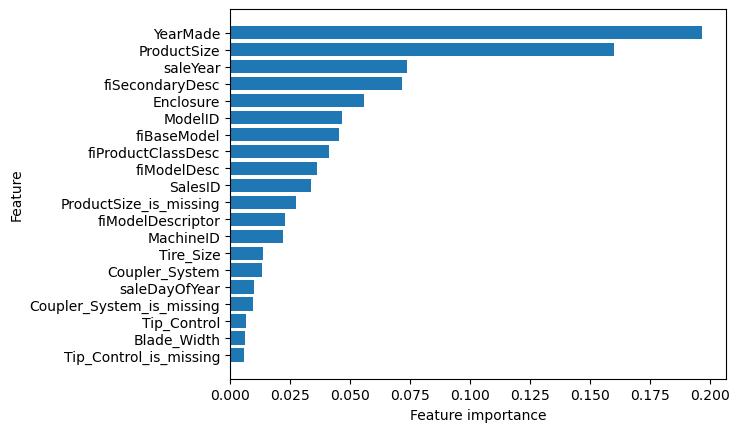

In [93]:
plot_features(X_train.columns, improved_model.feature_importances_)

The plot above shows the most 20 important features. 
It is worth to notice that `YearMade` and `ProductSize` have the most influence in predicting the `SalePrice`.

In [94]:
df["ProductSize"].value_counts()

ProductSize
Medium            64342
Large / Medium    51297
Small             27057
Mini              25721
Large             21396
Compact            6280
Name: count, dtype: int64

In [95]:
df["fiSecondaryDesc"].value_counts()

fiSecondaryDesc
C         44431
B         40165
G         37915
H         24729
E         21532
          ...  
BLGPPS        1
MSR           1
LC7A          1
CL            1
BH            1
Name: count, Length: 177, dtype: int64